In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/race_data_0523.zip'
extracted_folder_path = '/content/SWM-Group8'

if not os.path.exists(extracted_folder_path):
  # Create the destination folder if it doesn't exist
  os.makedirs(extracted_folder_path, exist_ok=True)

  # Open the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      # Extract all contents to the destination folder
      zip_ref.extractall(extracted_folder_path)

print(f'Zip file "{zip_file_path}" has been extracted to "{extracted_folder_path}".')


Zip file "/content/drive/MyDrive/race_data_0523.zip" has been extracted to "/content/SWM-Group8".


The below cell reads from one of the csv files instead of all 3 (which we shall do later) and parses the created_at column in the csv as a date field. It also filters tweets that retweets and is put in a dataframe called retweets_df. We also pickle this retweets file so we can just read the pickle file later.

In [ ]:
import pandas as pd
import os
import pickle

main_df = "/content/drive/MyDrive/main_df.pkl"

if not os.path.exists(main_df):
    file_path1 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-01_2023-05-14.csv'
    file_path2 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-15_2023-05-23.csv'
    file_path3 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-24_2023-05-31.csv'

    # Define the columns you need
    columns = ['tweet_id', 'tweet_text', 'user_id']

    # Initialize an empty DataFrame
    dataframes = []

    # Process each file in chunks
    for file_path in [file_path1, file_path2, file_path3]:
        for chunk in pd.read_csv(file_path, dtype=str, usecols=columns, chunksize=10000):
            dataframes.append(chunk)

    # Concatenate the processed chunks into a single DataFrame
    df = pd.concat(dataframes, ignore_index=True)

    # Save the DataFrames to pickle files
    with open(main_df, 'wb') as f:
      pickle.dump(df, f)

else:
    with open(main_df, 'rb') as file:
      df = pickle.load(file)


In [ ]:
import pandas as pd
import os
import pickle

file_retweets_df = "/content/drive/MyDrive/retweets_df.pkl"
main_df = "/content/drive/MyDrive/main_df.pkl"

retweets_df = None

if not os.path.exists(file_retweets_df):
    file_path1 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-01_2023-05-14.csv'
    file_path2 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-15_2023-05-23.csv'
    file_path3 = '/content/SWM-Group8/race_data_0523/race_tw_2023-05-24_2023-05-31.csv'

    # Define the columns you need
    columns = ['tweet_id', 'parent_tweet_id', 'tweet_text', 'tweet_type', 'created_at', 'user_id', 'parent_user_id']

    # Initialize an empty DataFrame
    retweets_df_list = []

    # Process each file in chunks
    for file_path in [file_path1, file_path2, file_path3]:
        for chunk in pd.read_csv(file_path, dtype=str, usecols=columns, parse_dates=["created_at"], chunksize=10000):
            retweets_chunk = chunk[chunk['tweet_type'] == 'retweet']
            retweets_df_list.append(retweets_chunk)

    # Concatenate the processed chunks into a single DataFrame
    retweets_df = pd.concat(retweets_df_list, ignore_index=True)

    # Convert 'created_at' to datetime
    retweets_df['created_at'] = pd.to_datetime(retweets_df['created_at'])

    # Sort by 'created_at'
    retweets_df = retweets_df.sort_values(by='created_at')

    print(f"The number of unique users in the dataset is '{retweets_df['user_id'].nunique()}")

    # Save the DataFrames to pickle files
    with open(file_retweets_df, 'wb') as f:
        pickle.dump(retweets_df, f)

else:
    with open(file_retweets_df, 'rb') as file:
        # Load the data from the pickle file
        retweets_df = pickle.load(file)


In [ ]:
retweets_df.shape

(8367131, 7)

In [ ]:
retweets_df.head(3)

,tweet_id,parent_tweet_id,tweet_text,tweet_type,created_at,user_id,parent_user_id
924516,1652825156757118977,1652126050774659073,"Megan Kelly throat punches Sunny Hostin, she l...",retweet,2023-05-01,1344493564177358850,1518703170700075009
2474651,1652825158086717443,1652737059189039107,The @Moms4Liberty are showing their whole ass ...,retweet,2023-05-01,43431843,1455183244513746949
461928,1652825158531313670,1652757809145032705,FLASHBACK: 12 years ago Joe Biden delivered a ...,retweet,2023-05-01,1604691888275087360,818610876206956544


# HIGHLY SYNCHRONOUS BEHAVIOR

The below piece of code has 2 maps for the two bins the paper suggested to create.

One for a particular user the time difference between subsequent retweets.

Two for a tweet time difference between subsequent retweets by different users.

In [ ]:
sbn1_list_map = dict()
sbn2_list_map = dict()

for index, row in retweets_df.iterrows():
  tweet_id = row[0]
  parent_tweet_id = row[1]
  created_at = row[4]
  user_id = row[5]
  parent_user_id = row[6]

  if user_id not in sbn1_list_map:
    sbn1_list_map[user_id] = []
  sbn1_list_map[user_id].append((created_at, user_id))

  if parent_tweet_id not in sbn2_list_map:
    sbn2_list_map[parent_tweet_id] = []
  sbn2_list_map[parent_tweet_id].append((created_at, user_id))

In [ ]:
from datetime import datetime

td1 = [0] * 30

for user_id in sbn1_list_map.keys():
  for i in range(1, len(sbn1_list_map[user_id])-1):
    # print(sbn1_list_map[user_id])
    td = round(sbn1_list_map[user_id][i][0].timestamp() - sbn1_list_map[user_id][i-1][0].timestamp())
    if td >= 30:
      # Ignore if its greater than 30 seconds
      continue
    else:
      td1[td]+=1


The below bar graph is a plot of the number of users vs the difference between their subsequent retweets.

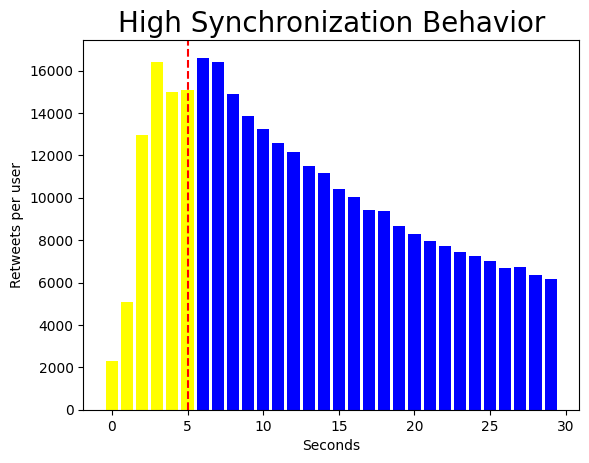

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of indices (0 to 29)
data = td1
indices = np.arange(len(data))

plt.title("High Synchronization Behavior", fontsize=20)

colors = ['yellow' if i <= 5 else 'blue' for i in indices]

plt.bar(indices, data, color=colors)

plt.axvline(x=5, color='red', linestyle='--', label='Line at Index 3')

# Set labels for the x and y axes
plt.xlabel("Seconds")
plt.ylabel("Retweets per user")

# Show the plot
plt.show()


We see that there is abnormal retweets for upto 5 seconds. So we will filter out all the tweets that fall under this category.

In [ ]:
ELBOW_POINT = 5

synchronized_users = []

for user_id in sbn1_list_map.keys():
  for i in range(1, len(sbn1_list_map[user_id])-1):
    td = round(sbn1_list_map[user_id][i][0].timestamp() - sbn1_list_map[user_id][i-1][0].timestamp())
    if td <= ELBOW_POINT:
      synchronized_users.append(sbn1_list_map[user_id][i][1])

synchronized_users = list(set(synchronized_users))
print(f"Total number of suspect users: {len(synchronized_users)}")

Total number of suspect users: 19331


In [ ]:
sync_users = "/content/drive/MyDrive/sync_users.pkl"
with open(sync_users, 'wb') as file:
  pickle.dump(synchronized_users, file)

In [ ]:
sync_users = "/content/drive/MyDrive/sync_users.pkl"
with open(sync_users, 'rb') as file:
  synchronized_users = pickle.load(file)

print(len(synchronized_users))

19331


In [ ]:
filtered_retweets_df = retweets_df[retweets_df['user_id'].isin(synchronized_users)]

unique_users = filtered_retweets_df['user_id'].unique()
print(len(unique_users))

19331


In [ ]:
import networkx as nx
import threading
from tqdm import tqdm
import concurrent.futures


threads = []

unique_users = filtered_retweets_df['user_id'].unique()

user_df_map_filename = "/content/drive/MyDrive/user_df_map.pkl"

if os.path.exists(user_df_map_filename):
  user_df_map = pickle.load(open(user_df_map_filename, 'rb'))
else:
  user_df_map = {}

  def cache(user_id):
    user_df = retweets_df[retweets_df['user_id'] == user_id]
    user_df_map[user_id] = user_df

  for index, user_id in enumerate(unique_users):
    thread = threading.Thread(target=cache, args=(user_id,))
    threads.append(thread)

  for thread in tqdm(threads):
      thread.start()

  with open('user_df_map.pickle', 'wb') as file:
    pickle.dump(user_df_map, file)

In [ ]:
import networkx as nx
import threading
from tqdm import tqdm
import concurrent.futures


unique_users = filtered_retweets_df['user_id'].unique()

G = nx.Graph()

G_filename = "/content/drive/MyDrive/coord_graph.pkl"

if os.path.exists(G_filename):
  G = pickle.load(open(G_filename, 'rb'))
  print(len(G.nodes()))
else:

  def add_edge(user_id1, user_id2):
    user1_df = user_df_map[user_id1]
    user2_df = user_df_map[user_id2]
    common_parent_tweet_ids = set(user1_df['parent_tweet_id']).intersection(user2_df['parent_tweet_id'])

    # Count the number of common parent_tweet_ids
    common_rows_count = len(common_parent_tweet_ids)

    if common_rows_count != 0:
        # Add nodes and edges to the graph
        G.add_node(user_id1)
        G.add_node(user_id2)
        G.add_edge(user_id1, user_id2, weight=common_rows_count)
  for index, user_id1 in tqdm(enumerate(unique_users), total=len(unique_users)):
    for user_id2 in unique_users[index+1:]:
        if user_id1 == user_id2:
            continue
        add_edge(user_id1, user_id2)

  # Access nodes, edges, and their attributes
  print("Nodes:", len(G.nodes()))
  # print("Edges with attributes:", G.edges(data=True))

  with open(G_filename, 'wb') as file:
    pickle.dump(G, file)


100%|██████████| 19331/19331 [1:33:07<00:00,  3.46it/s] 

Nodes: 18959


In [ ]:
import pandas as pd
import os
import pickle

G_filename = "/content/drive/MyDrive/coord_graph.pkl"

G = pickle.load(open(G_filename, 'rb'))
print(len(G.nodes()))

18959


In [ ]:
high_coord_users_path = '/content/drive/MyDrive/coord_users.pkl'

if os.path.exists(high_coord_users_path):
  high_coord_users = pickle.load(open(high_coord_users_path, 'rb'))
  print(len(high_coord_users))
else:
  edges_with_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]

  # Sort the edges by weight in descending order
  sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

  MAX_RETWEET_PAIR_COUNT = 70 #changed from 50 to 70
  high_coord_users = set()

  for u, v, w in tqdm(sorted_edges):
    if w >= MAX_RETWEET_PAIR_COUNT:
      continue
    elif w > 30:
      high_coord_users.add(u)
      high_coord_users.add(v)

  print(len(high_coord_users))

  with open(high_coord_users_path, 'wb') as file:
      pickle.dump(high_coord_users, file)

3804


In [ ]:
edges_with_weights = [(u, v, G[u][v]['weight']) for u, v in G.edges()]

# Sort the edges by weight in descending order
sorted_edges = sorted(edges_with_weights, key=lambda x: x[2], reverse=True)

MAX_RETWEET_PAIR_COUNT = 70 #changed from 50 to 70

td = [0] * MAX_RETWEET_PAIR_COUNT

for u, v, w in sorted_edges:
  if w >= MAX_RETWEET_PAIR_COUNT:
    continue

  td[w]+=1

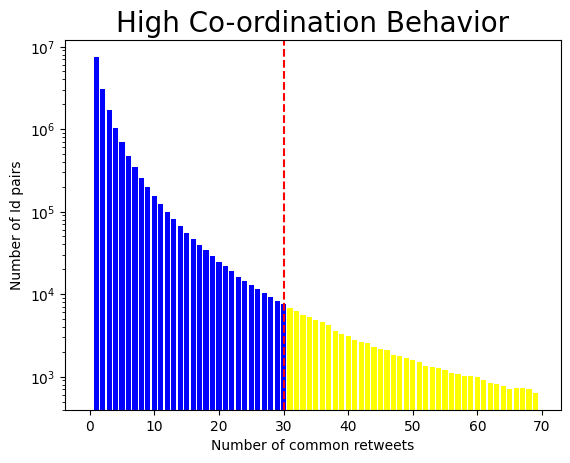

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ELBOW_POINT = 30 #changed from 25 to 30

# Create an array of indices (0 to 29)
data = td
indices = np.arange(len(data))

colors = ['yellow' if i > ELBOW_POINT else 'blue' for i in indices]

plt.title("High Co-ordination Behavior", fontsize=20)

# Create a histogram plot
plt.bar(indices, data, color=colors)
plt.yscale('log')  # Set y-axis to a logarithmic scale
plt.axvline(x=ELBOW_POINT, color='red', linestyle='--', label='Line at Index 21')

# Set labels for the x and y axes
plt.xlabel("Number of common retweets")
plt.ylabel("Number of Id pairs")

# Show the plot
plt.show()

HIGH COORDINATION

---

The graph illustrates instances of high coordination between pairs of user-ids. Coordination is deemed 'high' when a pair of user-ids retweet a substantial number of tweets in common, specifically exceeding 25 shared retweets.

In [4]:
import os
import pickle

if not os.path.exists("/content/drive/MyDrive/puppet_tweets.pkl"):
  puppet_tweets = set()
  puppet_users = set()

  i = 1
  for user in high_coord_users:
    new_df = retweets_df.loc[retweets_df['user_id'] == user]
    for index, row in new_df.iterrows():
      # print(row["tweet_text"])
      puppet_tweets.add(row["parent_tweet_id"])
      puppet_users.add(row["parent_user_id"])
    if(i%100 == 0):
      print(f"user {i} done")
    i += 1
  with open("/content/drive/MyDrive/puppet_tweets.pkl", "wb") as file:
    pickle.dump(puppet_tweets, file)
  with open("/content/drive/MyDrive/puppet_users.pkl", "wb") as file:
    pickle.dump(puppet_users, file)
else:
  with open("/content/drive/MyDrive/puppet_tweets.pkl", "rb") as file:
    puppet_tweets = pickle.load(file)
  with open("/content/drive/MyDrive/puppet_users.pkl", "rb") as file:
    puppet_users = pickle.load(file)

In [5]:
print(len(puppet_tweets), len(puppet_users))

84415 33222


# Visualize 4 camps


In [7]:
import pandas as pd


user_type_file = '/content/drive/MyDrive/user_type_individual.csv'

user_type_df = pd.read_csv(user_type_file, dtype=str)
dataframes = [user_type_df]

user_type_df = pd.concat(dataframes, ignore_index=True)

filtered_df = user_type_df[user_type_df['user_id'].isin(puppet_users)]

bot_types = filtered_df.groupby('type').size().to_dict()

print(bot_types)

{'Camp1 - Bound': 3426, 'Camp1 - Crossing': 2038, 'Camp2 - Bound': 6266, 'Camp2 - Crossing': 2366}


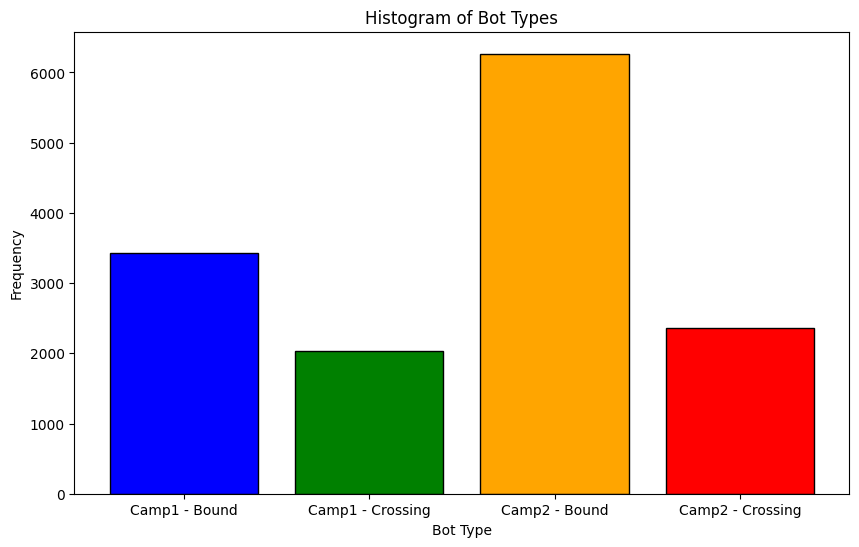

In [8]:
import matplotlib.pyplot as plt
import numpy as np

camps = list(bot_types.keys())
frequencies = list(bot_types.values())
colors = ['blue', 'green', 'orange', 'red']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(camps, frequencies, color=colors, edgecolor='black')

plt.title('Histogram of Bot Types')
plt.xlabel('Bot Type')
plt.ylabel('Frequency')

plt.show()

#Cloud Visualization of the hashtags

In [ ]:
import re
# Extract hashtags from tweet text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

In [ ]:
from collections import Counter

selected_tweets = df[df["tweet_id"].isin(puppet_tweets)].copy()
selected_tweets['hashtags'] = selected_tweets['tweet_text'].apply(extract_hashtags)
all_hashtags = [item for sublist in selected_tweets['hashtags'].tolist() for item in sublist]
hashtag_counts = Counter(all_hashtags)
hashtag_array = [[hashtag, count] for hashtag, count in hashtag_counts.items()]
len(hashtag_array)

10849

In [ ]:
# Remove elements containing "Shiv" or '#KhatronKeKhiladi13'
filtered_hashtags_and_counts = [item for item in hashtag_array if 'Shiv' not in item[0] and
                                '#KhatronKeKhiladi13' not in item[0] and
                                'KKK13' not in item[0] and
                                'kkk13' not in item[0]]

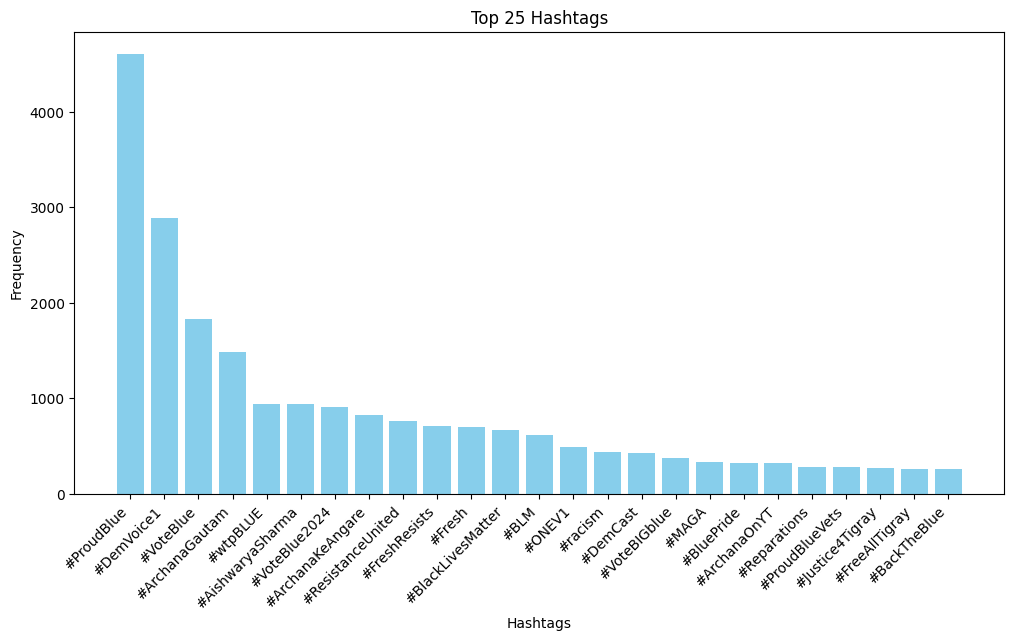

In [ ]:
top_hashtags = sorted(filtered_hashtags_and_counts, key=lambda x: x[1], reverse=True)[:25]

hashtags, counts = zip(*top_hashtags)

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_hashtags)), counts, tick_label=hashtags, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Hashtags')
plt.ylabel('Frequency')
plt.title('Top 25 Hashtags')

plt.show()

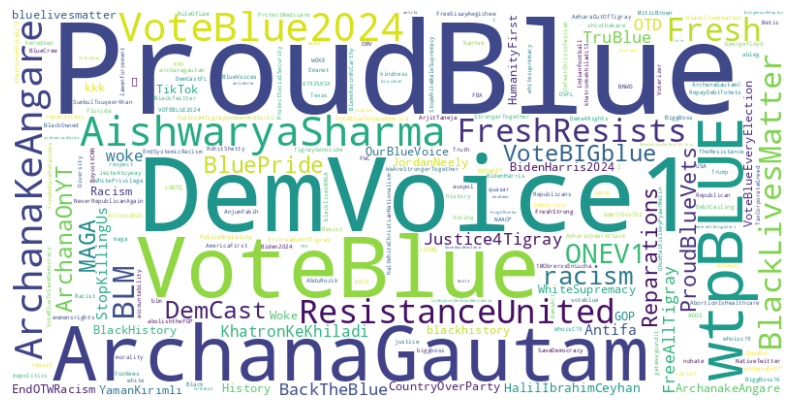

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

hashtag_dict = {tag[1:]: count for tag, count in filtered_hashtags_and_counts}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtag_dict)

# Plot the WordCloud image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#End


In [ ]:
from datetime import datetime

td2 = [0] * 30

for parent_tweet_id in sbn2_list_map.keys():
  for i in range(1, len(sbn2_list_map[parent_tweet_id])-1):
    td = round(sbn2_list_map[parent_tweet_id][i][0].timestamp() - sbn2_list_map[parent_tweet_id][i-1][0].timestamp())
    if td >= 30:
      # Ignore if its greater than 30 seconds
      continue
    else:
      td2[td]+=1

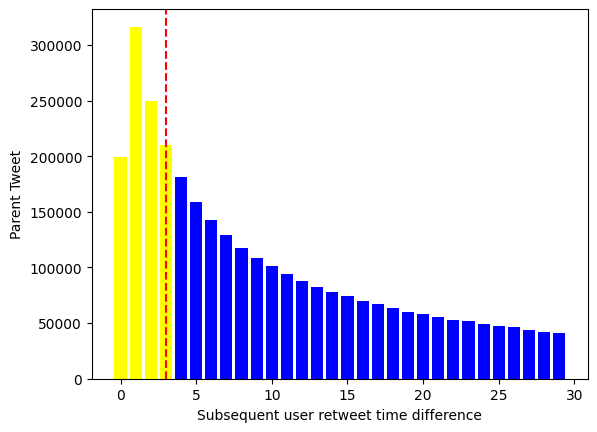

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of indices (0 to 29)
data = td2
indices = np.arange(len(data))

colors = ['yellow' if i <= 3 else 'blue' for i in indices]

# Create a histogram plot
plt.bar(indices, data, color=colors)

plt.axvline(x=3, color='red', linestyle='--', label='Line at Index 3')

# Set labels for the x and y axes
plt.xlabel("Subsequent user retweet time difference")
plt.ylabel("Parent Tweet")

# Show the plot
plt.show()

In [ ]:
import numpy as np

ELBOW_POINT = 3

if not os.path.exists("/content/drive/MyDrive/suspect_tweets.pkl.npy"):
  suspect_tweets = []

  for user_id in sbn2_list_map.keys():
    for i in range(1, len(sbn2_list_map[user_id])-1):
      td = round(sbn2_list_map[user_id][i][0].timestamp() - sbn2_list_map[user_id][i-1][0].timestamp())
      if td <= ELBOW_POINT:
        suspect_tweets.append(sbn2_list_map[user_id][i][1])

  suspect_tweets = list(set(suspect_tweets))
  print(f"Total number of suspect tweets: {len(suspect_tweets)}")
  suspect_tweets_pickle = "/content/drive/MyDrive/suspect_tweets.pkl"
  np.save(suspect_tweets_pickle, suspect_tweets, allow_pickle=True, fix_imports=True)

else:
  suspect_tweets = np.load("/content/drive/MyDrive/suspect_tweets.pkl.npy")
  print(f"Total number of suspect tweets: {len(suspect_tweets)}")

Total number of suspect tweets: 521212


In [ ]:
print(suspect_tweets[0])

1594336617661141004


In [ ]:
print(df.loc[df["user_id"] == "2379765100"]["tweet_text"].index[0])
print(df.iloc[df.loc[df["user_id"] == "2379765100"]["tweet_text"].index[0]]["tweet_text"])

13246987
To grow up in Tennessee, picking cotton,  be abandoned by both parents, survive an abusive relationship, battle with ageism, sexism, and racism just to come out as one of the best performers of all time.

You’ve fought the good fight and won, rest in power Tina Turner! https://t.co/WbwPSwdSrw


Above block is for retrieving parent tweet text based on user id in suspect tweets.